# Ekstraksi Kata Kunci dengan Word Graph dan Analisis Sentralitas

Notebook ini melakukan ekstraksi kata kunci dari dokumen PDF menggunakan metode word graph dan berbagai pengukuran sentralitas (PageRank, Degree Centrality, Betweenness Centrality, dan Closeness Centrality).

In [62]:
%pip install pymupdf nltk networkx pandas numpy matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


## 1. Instalasi Paket yang Diperlukan

Menginstal semua library Python yang dibutuhkan untuk:
- **pymupdf**: Ekstraksi teks dari file PDF
- **nltk**: Natural Language Processing (tokenisasi, stopwords)
- **networkx**: Pembuatan dan analisis graf
- **pandas**: Manipulasi data
- **numpy**: Operasi numerik
- **matplotlib**: Visualisasi graf

## 2. Ekstraksi Teks dari PDF

Mengekstrak seluruh teks dari file PDF dan menyimpannya ke dalam file `output.txt`. Setiap halaman dipisahkan dengan karakter form feed.

In [63]:
# Ekstraksi teks dari PDF
import pymupdf

# Buka file PDF
doc = pymupdf.open("garuda1825910.pdf")
# Buat file output untuk menyimpan teks
out = open("output.txt", "wb")

# Loop setiap halaman dalam dokumen
for page in doc:
    text = page.get_text().encode("utf8")  # Ambil teks dari halaman
    out.write(text)  # Tulis teks ke file
    out.write(bytes((12,)))  # Tulis pemisah halaman (form feed)
out.close()
print("Ekstraksi PDF selesai.")

Ekstraksi PDF selesai.


## 3. Download Resource NLTK

Mengunduh resource yang dibutuhkan untuk Natural Language Processing:
- **punkt**: Tokenizer untuk memisahkan teks menjadi kalimat
- **stopwords**: Daftar kata-kata umum yang tidak bermakna (stop words)

In [64]:
# Download resource NLTK
import nltk
nltk.download('punkt')  # Untuk tokenisasi kalimat
nltk.download('punkt_tab')  # Versi terbaru tokenizer
nltk.download('stopwords')  # Daftar stopwords

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\NITRO\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\NITRO\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\NITRO\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## 4. Tokenisasi Teks Menjadi Kalimat

Membaca file teks yang telah diekstrak, kemudian memecahnya menjadi kalimat-kalimat individual dan menyimpannya dalam file CSV.

In [65]:
# Baca dan tokenisasi teks menjadi kalimat
import pandas as pd

# Baca file teks hasil ekstraksi PDF
with open('output.txt', 'r', encoding='utf-8') as file:
    teks = file.read()

# Pisahkan teks menjadi kalimat-kalimat
sentences = nltk.sent_tokenize(teks)
# Simpan kalimat ke dalam DataFrame
df = pd.DataFrame(sentences, columns=['kalimat'])
# Simpan ke file CSV
df.to_csv('kalimat.csv', index=False, encoding='utf-8')
print(f"Total kalimat: {len(sentences)}")

Total kalimat: 211


## 5. Pembuatan Matriks Ko-okurensi dengan Unigram dan Bigram

Proses ini melakukan:
1. **Preprocessing teks**: Membersihkan teks dari angka, karakter khusus, dan stopwords
2. **Ekstraksi unigram**: Kata tunggal yang bermakna
3. **Ekstraksi bigram**: Gabungan 2 kata berurutan
4. **Matriks ko-okurensi**: Menghitung kemunculan bersama antar kata dalam jendela tertentu

In [66]:
# Membangun matriks ko-okurensi dengan unigram dan bigram
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from collections import defaultdict, Counter
import numpy as np
import re

# Baca file CSV kalimat
df = pd.read_csv("kalimat.csv")
# Gabungkan semua kalimat menjadi satu teks
text = " ".join(df.iloc[:,0].astype(str))

# Preprocessing teks: hapus angka dan karakter khusus
stop_words = set(stopwords.words('english') + stopwords.words('indonesian'))
words = word_tokenize(text.lower())  # Tokenisasi dan ubah ke huruf kecil

# Filter: hanya kata alfabetik, tanpa angka, tanpa karakter tunggal, bukan stopwords
unigrams = [word for word in words if word.isalpha() and len(word) > 1 and word not in stop_words]

# Generasi bigram (gabungan 2 kata)
bigrams_raw = list(ngrams(unigrams, 2))
bigrams_formatted = [f"{word1} {word2}" for word1, word2 in bigrams_raw]

# Gabungkan unigram dan bigram
processed_terms = unigrams + bigrams_formatted

# Tentukan ukuran jendela untuk ko-okurensi
window_size = 2

# Buat struktur ko-okurensi awal berbasis jendela
co_occurrences = defaultdict(Counter)
for i, term in enumerate(processed_terms):
    # Untuk setiap term, cek term di sekitarnya dalam jendela
    for j in range(max(0, i - window_size), min(len(processed_terms), i + window_size + 1)):
        if i != j:
            co_occurrences[term][processed_terms[j]] += 1

# Tambahkan hubungan eksplisit antara bigram dan dua unigram penyusunnya
for (word1, word2), bigram in zip(bigrams_raw, bigrams_formatted):
    # Bigram terhubung ke kedua kata pembentuknya
    co_occurrences[bigram][word1] += 1
    co_occurrences[bigram][word2] += 1
    co_occurrences[word1][bigram] += 1
    co_occurrences[word2][bigram] += 1

# Dapatkan list term unik
unique_terms = list(set(processed_terms))
# Inisialisasi matriks ko-okurensi
co_matrix = np.zeros((len(unique_terms), len(unique_terms)), dtype=int)

# Isi matriks dengan nilai ko-okurensi
term_index = {term: idx for idx, term in enumerate(unique_terms)}
for term, neighbors in co_occurrences.items():
    for neighbor, count in neighbors.items():
        co_matrix[term_index[term]][term_index[neighbor]] = count

# Buat DataFrame dari matriks
co_matrix_df = pd.DataFrame(co_matrix, index=unique_terms, columns=unique_terms)
print(f"Matriks ko-okurensi dibuat: {co_matrix_df.shape}")
print(f"Total term unik (unigram + bigram): {len(unique_terms)}")

Matriks ko-okurensi dibuat: (2209, 2209)
Total term unik (unigram + bigram): 2209


## 5.1. Tampilan Tabel Matriks Ko-okurensi (Top 20 Kata)

Menampilkan matriks ko-okurensi dalam bentuk tabel untuk 20 kata dengan frekuensi ko-okurensi tertinggi. Tabel ini memudahkan kita untuk:
- Melihat nilai numerik hubungan antar kata
- Mengidentifikasi pasangan kata yang sering muncul bersama
- Memahami kekuatan hubungan berdasarkan frekuensi kemunculan

Nilai dalam matriks menunjukkan berapa kali dua kata muncul berdekatan dalam jendela yang ditentukan (window size).

In [68]:
# Tampilkan sebagian kecil matriks ko-okurensi sebagai tabel (top 20 kata)
top_20_words = word_totals.head(20).index.tolist()
co_matrix_sample = co_matrix_df.loc[top_20_words, top_20_words]

print("="*80)
print("MATRIKS KO-OKURENSI - Top 20 Kata (Tampilan Tabel)")
print("="*80)
print(f"\nUkuran matriks: {co_matrix_sample.shape}")
print(f"\nNilai dalam matriks menunjukkan frekuensi kemunculan bersama antara dua kata.")
print(f"Semakin tinggi nilainya, semakin sering kedua kata muncul bersamaan dalam jendela yang sama.\n")

# Tampilkan matriks sebagai tabel
print(co_matrix_sample.to_string())
print("\n" + "="*80)


MATRIKS KO-OKURENSI - Top 20 Kata (Tampilan Tabel)

Ukuran matriks: (20, 20)

Nilai dalam matriks menunjukkan frekuensi kemunculan bersama antara dua kata.
Semakin tinggi nilainya, semakin sering kedua kata muncul bersamaan dalam jendela yang sama.

                   booklet  bumi  gempa  gempa bumi  bencana  tsunami  informasi  canva  pembuatan  bumi tsunami  pembuatan booklet  mitigasi  bencana gempa  masyarakat  pembahasan  mitigasi bencana  aplikasi  padang  media  booklet mitigasi
booklet                 20     1      0           0       21        2          6      6         38             0                 30        24              0           2           7                 0         4       2      4                21
bumi                     1    12     78          69       29       37          1      0          0            32                  0         0              0           4           5                 0         0       1      9                 0
gempa                   

In [70]:
# Buat graf dari matriks ko-okurensi
import networkx as nx

# Konversi matriks adjacency menjadi graf NetworkX
G = nx.from_pandas_adjacency(co_matrix_df)
print(f"Graf dibuat dengan {len(G.nodes)} node dan {len(G.edges)} edge.")

Graf dibuat dengan 2209 node dan 9736 edge.


🔄 Menghitung layout graph...
✅ Menggunakan Kamada-Kawai layout


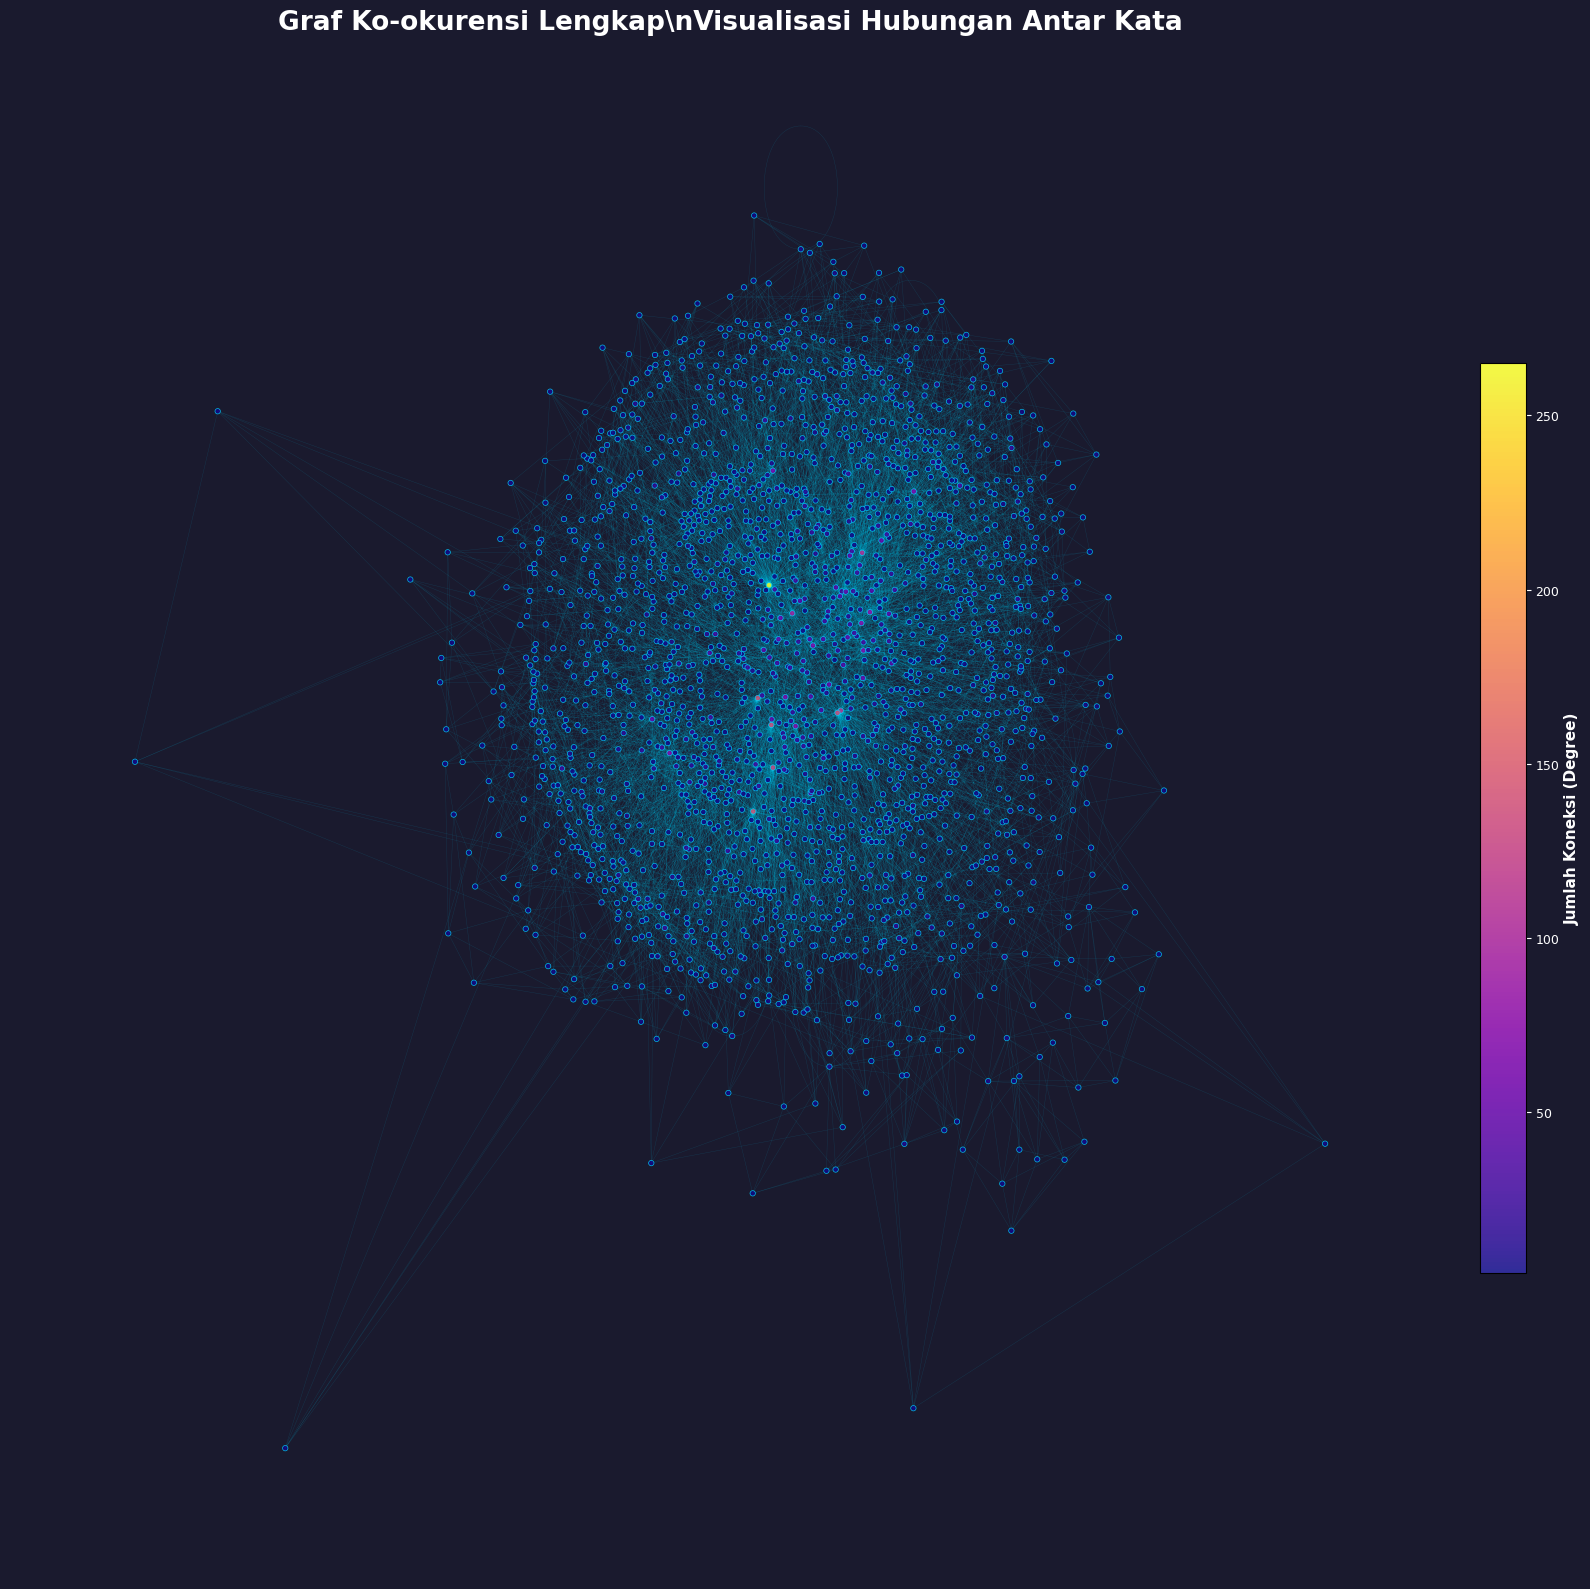

\n✅ Visualisasi menampilkan 2209 kata dengan 9736 hubungan
🎨 Warna node menunjukkan jumlah koneksi (degree centrality)


In [84]:
# Visualisasi graf ko-okurensi penuh dengan style modern
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(16, 16), facecolor='#1a1a2e')

# Gunakan layout yang berbeda untuk distribusi lebih baik
print("🔄 Menghitung layout graph...")
try:
    # Coba kamada-kawai untuk distribusi lebih baik
    pos = nx.kamada_kawai_layout(G, scale=2)
    print("✅ Menggunakan Kamada-Kawai layout")
except:
    # Fallback ke spring dengan parameter berbeda
    pos = nx.spring_layout(G, k=0.15, iterations=100, seed=42)
    print("✅ Menggunakan Spring layout")

# Hitung degree untuk gradient warna
degrees = dict(G.degree())
node_colors = [degrees[node] for node in G.nodes()]

# Gambar edges dengan gradient transparansi
nx.draw_networkx_edges(G, pos, width=0.3, alpha=0.15, edge_color='#00d9ff', style='solid', ax=ax)

# Gambar nodes dengan gradient warna berdasarkan degree
nodes = nx.draw_networkx_nodes(G, pos, 
                               node_size=15, 
                               node_color=node_colors,
                               cmap=plt.cm.plasma,  # Color scheme modern
                               alpha=0.85,
                               edgecolors='#00d9ff',
                               linewidths=0.5,
                               ax=ax)

# Tambahkan colorbar
cbar = plt.colorbar(nodes, ax=ax, fraction=0.03, pad=0.02)
cbar.set_label('Jumlah Koneksi (Degree)', color='white', fontsize=11, fontweight='bold')
cbar.ax.tick_params(colors='white', labelsize=9)

ax.set_title("Graf Ko-okurensi Lengkap\\nVisualisasi Hubungan Antar Kata", 
             fontsize=19, fontweight='bold', pad=20, color='white')
ax.axis('off')
ax.set_facecolor('#1a1a2e')

plt.tight_layout()
plt.show()

print(f"\\n✅ Visualisasi menampilkan {len(G.nodes())} kata dengan {len(G.edges())} hubungan")
print(f"🎨 Warna node menunjukkan jumlah koneksi (degree centrality)")


## 6. Pembuatan Graf dari Matriks Ko-okurensi

Mengkonversi matriks ko-okurensi menjadi graf NetworkX di mana:
- **Node**: Kata-kata (unigram dan bigram)
- **Edge**: Hubungan ko-okurensi antar kata
- **Bobot**: Frekuensi kemunculan bersama

## 7. Seleksi 20 Kata Kunci Teratas

Menghitung PageRank pada **graf penuh** dan memilih 20 kata dengan nilai tertinggi. PageRank mengukur kepentingan kata berdasarkan struktur hubungan dengan kata-kata lain dalam jaringan.

In [72]:
# Hitung PageRank pada graf penuh dan pilih 20 node teratas
pagerank_full = nx.pagerank(G)
# Urutkan node berdasarkan PageRank (tertinggi ke terendah)
top_20_nodes = sorted(pagerank_full.items(), key=lambda item: item[1], reverse=True)[:20]

print("\n20 Kata Teratas Berdasarkan PageRank (Graf Penuh):")
for i, (node, pr) in enumerate(top_20_nodes, 1):
    print(f"{i}. {node}: {pr:.4f}")


20 Kata Teratas Berdasarkan PageRank (Graf Penuh):
1. booklet: 0.0191
2. bumi: 0.0115
3. gempa: 0.0113
4. gempa bumi: 0.0103
5. tsunami: 0.0087
6. informasi: 0.0086
7. bencana: 0.0085
8. canva: 0.0072
9. pembuatan: 0.0059
10. pembuatan booklet: 0.0046
11. bumi tsunami: 0.0045
12. aplikasi: 0.0043
13. mitigasi: 0.0043
14. masyarakat: 0.0042
15. laut: 0.0041
16. pembahasan: 0.0041
17. bencana gempa: 0.0039
18. media: 0.0037
19. padang: 0.0037
20. desain: 0.0036


In [73]:
# Buat subgraf dengan 20 node teratas
top_node_names = [node for node, _ in top_20_nodes]
# Ekstrak subgraf yang hanya berisi 20 node teratas
subgraph = G.subgraph(top_node_names)
print(f"\nSubgraf dibuat dengan {len(subgraph.nodes)} node dan {len(subgraph.edges)} edge.")


Subgraf dibuat dengan 20 node dan 87 edge.


## 8. Pembuatan Subgraf

Membuat subgraf yang hanya berisi 20 node teratas beserta koneksi antar mereka untuk analisis yang lebih fokus.

## 9. Perhitungan Semua Ukuran Sentralitas

Menghitung 4 ukuran sentralitas yang berbeda untuk mengidentifikasi kata kunci penting:

1. **PageRank**: Mengukur kepentingan kata berdasarkan struktur jaringan (kata yang terhubung ke kata penting lain)
2. **Degree Centrality**: Mengukur jumlah koneksi langsung yang dimiliki kata
3. **Betweenness Centrality**: Mengukur seberapa sering kata menjadi jembatan antara kata lain
4. **Closeness Centrality**: Mengukur kedekatan rata-rata kata ke semua kata lain dalam jaringan

In [74]:
# Hitung semua ukuran sentralitas
print("\nMenghitung ukuran sentralitas...")

# 1. PageRank - Mengukur kepentingan node berdasarkan struktur link
pagerank_values = nx.pagerank(subgraph)
pagerank_df = pd.DataFrame(list(pagerank_values.items()), columns=['Kata', 'PageRank'])
pagerank_df = pagerank_df.sort_values(by='PageRank', ascending=False)

# 2. Degree Centrality - Mengukur jumlah koneksi langsung
degree_centrality_sub = nx.degree_centrality(subgraph)
degree_df = pd.DataFrame(list(degree_centrality_sub.items()), columns=['Kata', 'Degree_Centrality'])
degree_df = degree_df.sort_values(by='Degree_Centrality', ascending=False)

# 3. Betweenness Centrality - Mengukur seberapa sering node menjadi jembatan
betweenness_centrality = nx.betweenness_centrality(subgraph)
betweenness_df = pd.DataFrame(list(betweenness_centrality.items()), columns=['Kata', 'Betweenness_Centrality'])
betweenness_df = betweenness_df.sort_values(by='Betweenness_Centrality', ascending=False)

# 4. Closeness Centrality - Mengukur kedekatan node ke semua node lain
closeness_centrality = nx.closeness_centrality(subgraph)
closeness_df = pd.DataFrame(list(closeness_centrality.items()), columns=['Kata', 'Closeness_Centrality'])
closeness_df = closeness_df.sort_values(by='Closeness_Centrality', ascending=False)

print("Semua ukuran sentralitas berhasil dihitung.")


Menghitung ukuran sentralitas...
Semua ukuran sentralitas berhasil dihitung.


In [75]:
# Tampilkan hasil PageRank
print("\n" + "="*60)
print("PAGERANK CENTRALITY (Sentralitas PageRank)")
print("="*60)
print(pagerank_df.to_string(index=False))


PAGERANK CENTRALITY (Sentralitas PageRank)
             Kata  PageRank
            gempa  0.110033
             bumi  0.105514
          booklet  0.097200
       gempa bumi  0.074599
          bencana  0.069270
          tsunami  0.068388
        pembuatan  0.053681
     bumi tsunami  0.048137
    bencana gempa  0.044832
         mitigasi  0.040689
        informasi  0.039375
            canva  0.037669
pembuatan booklet  0.037164
       masyarakat  0.036088
         aplikasi  0.031967
            media  0.029384
       pembahasan  0.025496
           desain  0.020378
           padang  0.019917
             laut  0.010222


## 10. Hasil dan Visualisasi PageRank

PageRank menentukan kata kunci paling penting berdasarkan struktur jaringan. Kata dengan PageRank tinggi adalah kata yang terhubung dengan banyak kata penting lainnya.

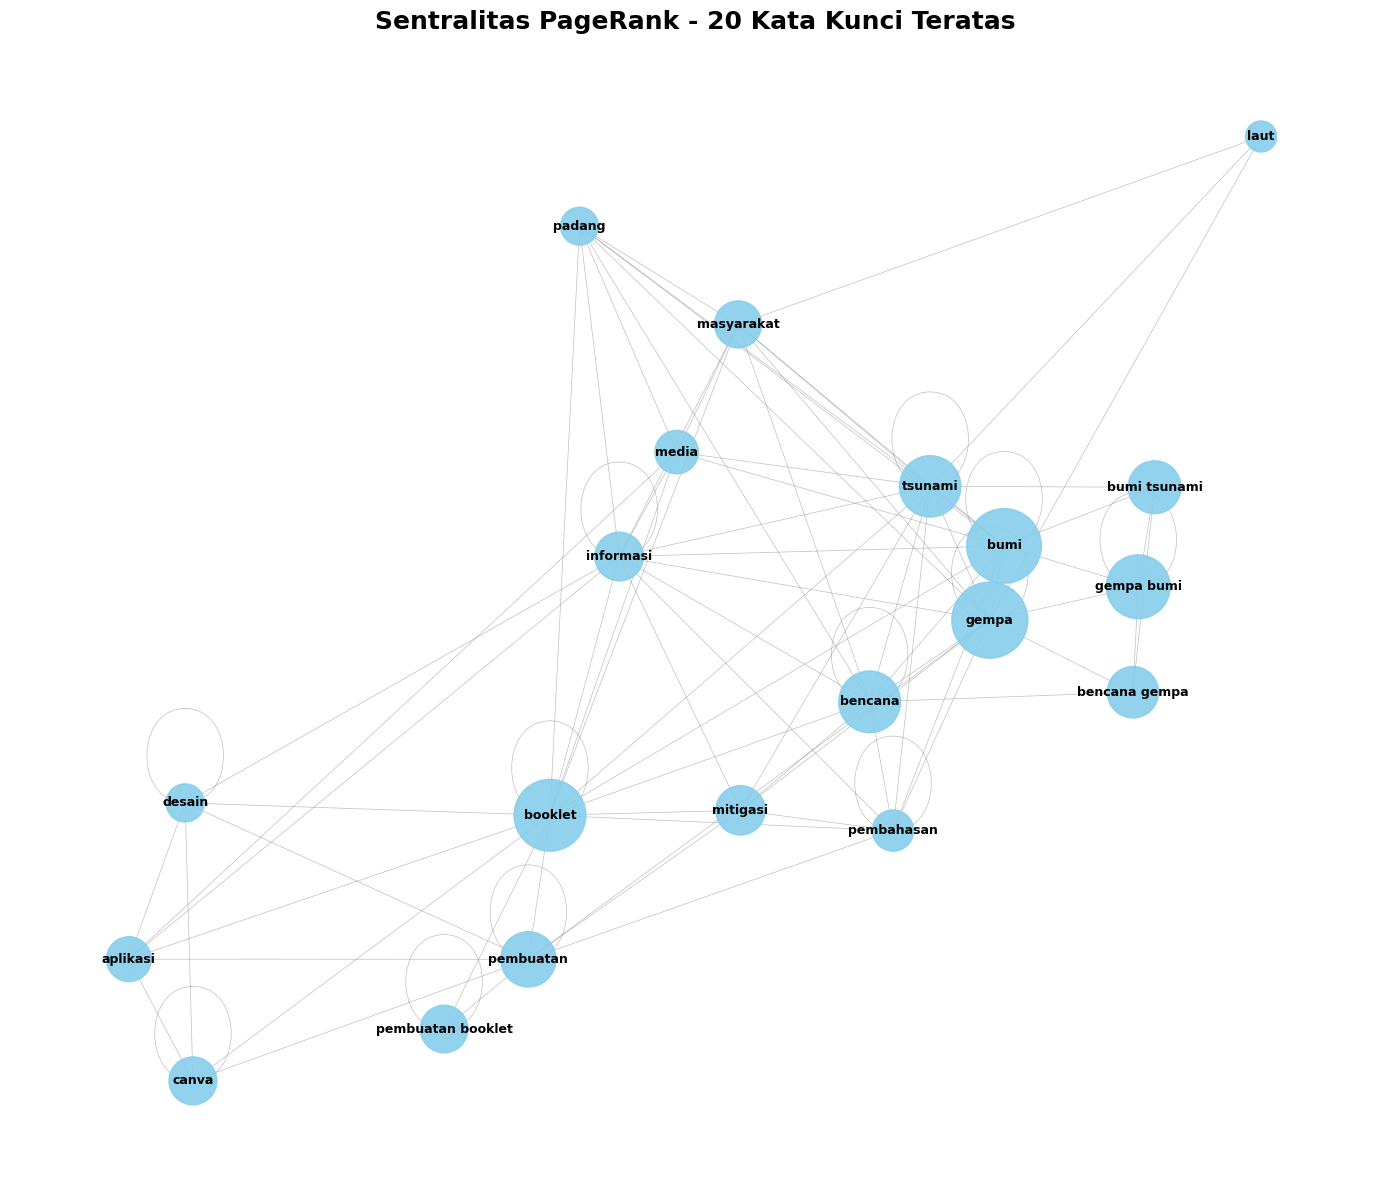

In [76]:
# Visualisasi PageRank
import matplotlib.pyplot as plt

# Buat figure dengan ukuran besar
plt.figure(figsize=(14, 12))
# Tentukan posisi node menggunakan spring layout
pos = nx.spring_layout(subgraph, k=0.8, iterations=50)

# Normalisasi ukuran node berdasarkan nilai PageRank
max_pr = max(pagerank_values.values())
min_pr = min(pagerank_values.values())
node_sizes = [500 + (v - min_pr) / (max_pr - min_pr) * 2500 if max_pr != min_pr else 1000 for v in pagerank_values.values()]

# Gambar node, edge, dan label
nx.draw_networkx_nodes(subgraph, pos, node_size=node_sizes, node_color='skyblue', alpha=0.9)
nx.draw_networkx_edges(subgraph, pos, width=0.5, alpha=0.5, edge_color='gray')
nx.draw_networkx_labels(subgraph, pos, font_size=9, font_weight='bold')

plt.title("Sentralitas PageRank - 20 Kata Kunci Teratas", fontsize=18, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()

In [77]:
# Tampilkan hasil Degree Centrality
print("\n" + "="*60)
print("DEGREE CENTRALITY (Sentralitas Derajat)")
print("="*60)
print(degree_df.to_string(index=False))


DEGREE CENTRALITY (Sentralitas Derajat)
             Kata  Degree_Centrality
          booklet           0.842105
          tsunami           0.736842
        informasi           0.736842
            gempa           0.736842
             bumi           0.684211
          bencana           0.631579
        pembuatan           0.526316
       pembahasan           0.526316
       masyarakat           0.473684
           padang           0.421053
           desain           0.368421
         mitigasi           0.368421
            media           0.368421
       gempa bumi           0.315789
         aplikasi           0.315789
            canva           0.315789
    bencana gempa           0.210526
     bumi tsunami           0.210526
pembuatan booklet           0.210526
             laut           0.157895


## 11. Hasil dan Visualisasi Degree Centrality

Degree Centrality mengidentifikasi kata yang memiliki koneksi terbanyak dengan kata lain. Semakin tinggi nilai degree centrality, semakin banyak kata yang berhubungan dengannya.

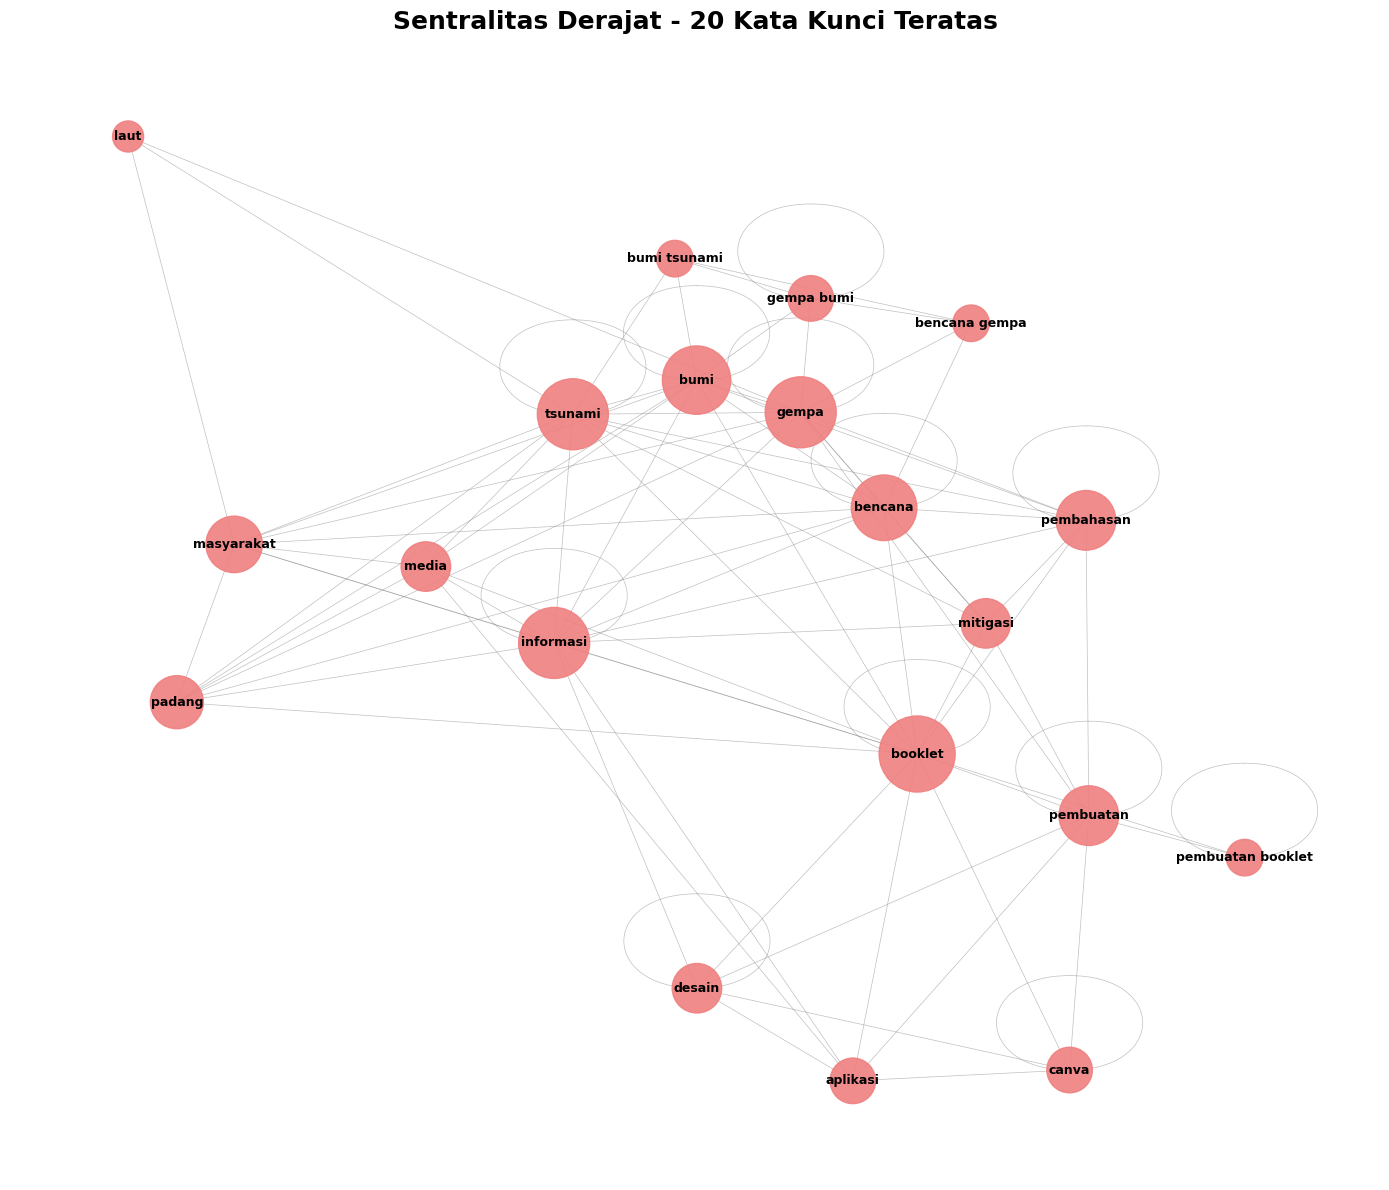

In [78]:
# Visualisasi Degree Centrality
plt.figure(figsize=(14, 12))
pos = nx.spring_layout(subgraph, k=0.8, iterations=50)

# Normalisasi ukuran node berdasarkan degree centrality
max_deg = max(degree_centrality_sub.values())
min_deg = min(degree_centrality_sub.values())
node_sizes = [500 + (v - min_deg) / (max_deg - min_deg) * 2500 if max_deg != min_deg else 1000 for v in degree_centrality_sub.values()]

nx.draw_networkx_nodes(subgraph, pos, node_size=node_sizes, node_color='lightcoral', alpha=0.9)
nx.draw_networkx_edges(subgraph, pos, width=0.5, alpha=0.5, edge_color='gray')
nx.draw_networkx_labels(subgraph, pos, font_size=9, font_weight='bold')

plt.title("Sentralitas Derajat - 20 Kata Kunci Teratas", fontsize=18, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()

In [79]:
# Tampilkan hasil Betweenness Centrality
print("\n" + "="*60)
print("BETWEENNESS CENTRALITY (Sentralitas Keantaraan)")
print("="*60)
print(betweenness_df.to_string(index=False))


BETWEENNESS CENTRALITY (Sentralitas Keantaraan)
             Kata  Betweenness_Centrality
          booklet                0.201620
            gempa                0.134122
          tsunami                0.087202
             bumi                0.082048
        informasi                0.074341
        pembuatan                0.069314
          bencana                0.043994
       masyarakat                0.025316
            media                0.012378
         aplikasi                0.010721
       pembahasan                0.008772
     bumi tsunami                0.006196
    bencana gempa                0.006010
         mitigasi                0.005198
       gempa bumi                0.003991
           padang                0.003629
           desain                0.002924
             laut                0.000000
pembuatan booklet                0.000000
            canva                0.000000


## 12. Hasil dan Visualisasi Betweenness Centrality

Betweenness Centrality mengidentifikasi kata yang berperan sebagai jembatan dalam jaringan. Kata dengan nilai tinggi menghubungkan kelompok kata yang berbeda.

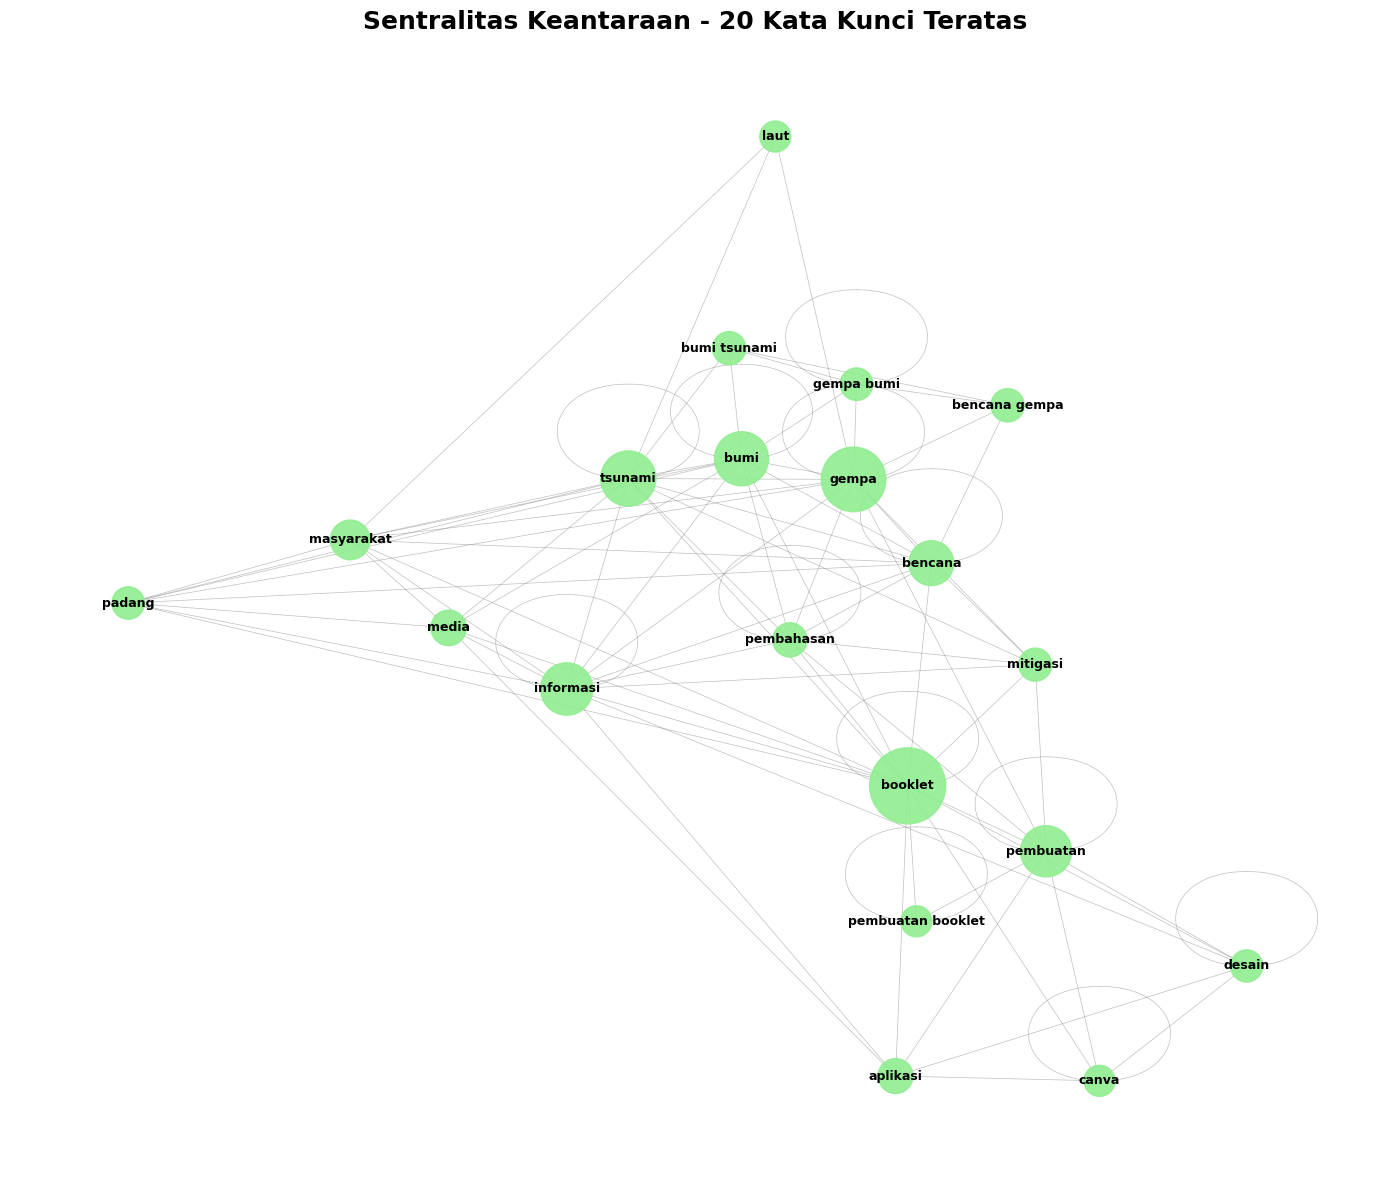

In [80]:
# Visualisasi Betweenness Centrality
plt.figure(figsize=(14, 12))
pos = nx.spring_layout(subgraph, k=0.8, iterations=50)

# Normalisasi ukuran node berdasarkan betweenness centrality
max_btw = max(betweenness_centrality.values())
min_btw = min(betweenness_centrality.values())
node_sizes = [500 + (v - min_btw) / (max_btw - min_btw) * 2500 if max_btw != min_btw else 1000 for v in betweenness_centrality.values()]

nx.draw_networkx_nodes(subgraph, pos, node_size=node_sizes, node_color='lightgreen', alpha=0.9)
nx.draw_networkx_edges(subgraph, pos, width=0.5, alpha=0.5, edge_color='gray')
nx.draw_networkx_labels(subgraph, pos, font_size=9, font_weight='bold')

plt.title("Sentralitas Keantaraan - 20 Kata Kunci Teratas", fontsize=18, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()

In [81]:
# Tampilkan hasil Closeness Centrality
print("\n" + "="*60)
print("CLOSENESS CENTRALITY (Sentralitas Kedekatan)")
print("="*60)
print(closeness_df.to_string(index=False))


CLOSENESS CENTRALITY (Sentralitas Kedekatan)
             Kata  Closeness_Centrality
          booklet              0.791667
          tsunami              0.730769
        informasi              0.730769
            gempa              0.730769
             bumi              0.703704
          bencana              0.678571
       masyarakat              0.655172
       pembahasan              0.633333
           padang              0.633333
        pembuatan              0.612903
         mitigasi              0.612903
            media              0.593750
         aplikasi              0.527778
           desain              0.513514
       gempa bumi              0.500000
            canva              0.500000
             laut              0.487179
    bencana gempa              0.487179
     bumi tsunami              0.487179
pembuatan booklet              0.475000


## 13. Hasil dan Visualisasi Closeness Centrality

Closeness Centrality mengukur seberapa dekat sebuah kata dengan semua kata lainnya. Kata dengan nilai tinggi dapat dengan cepat terhubung ke kata lain dalam jaringan.

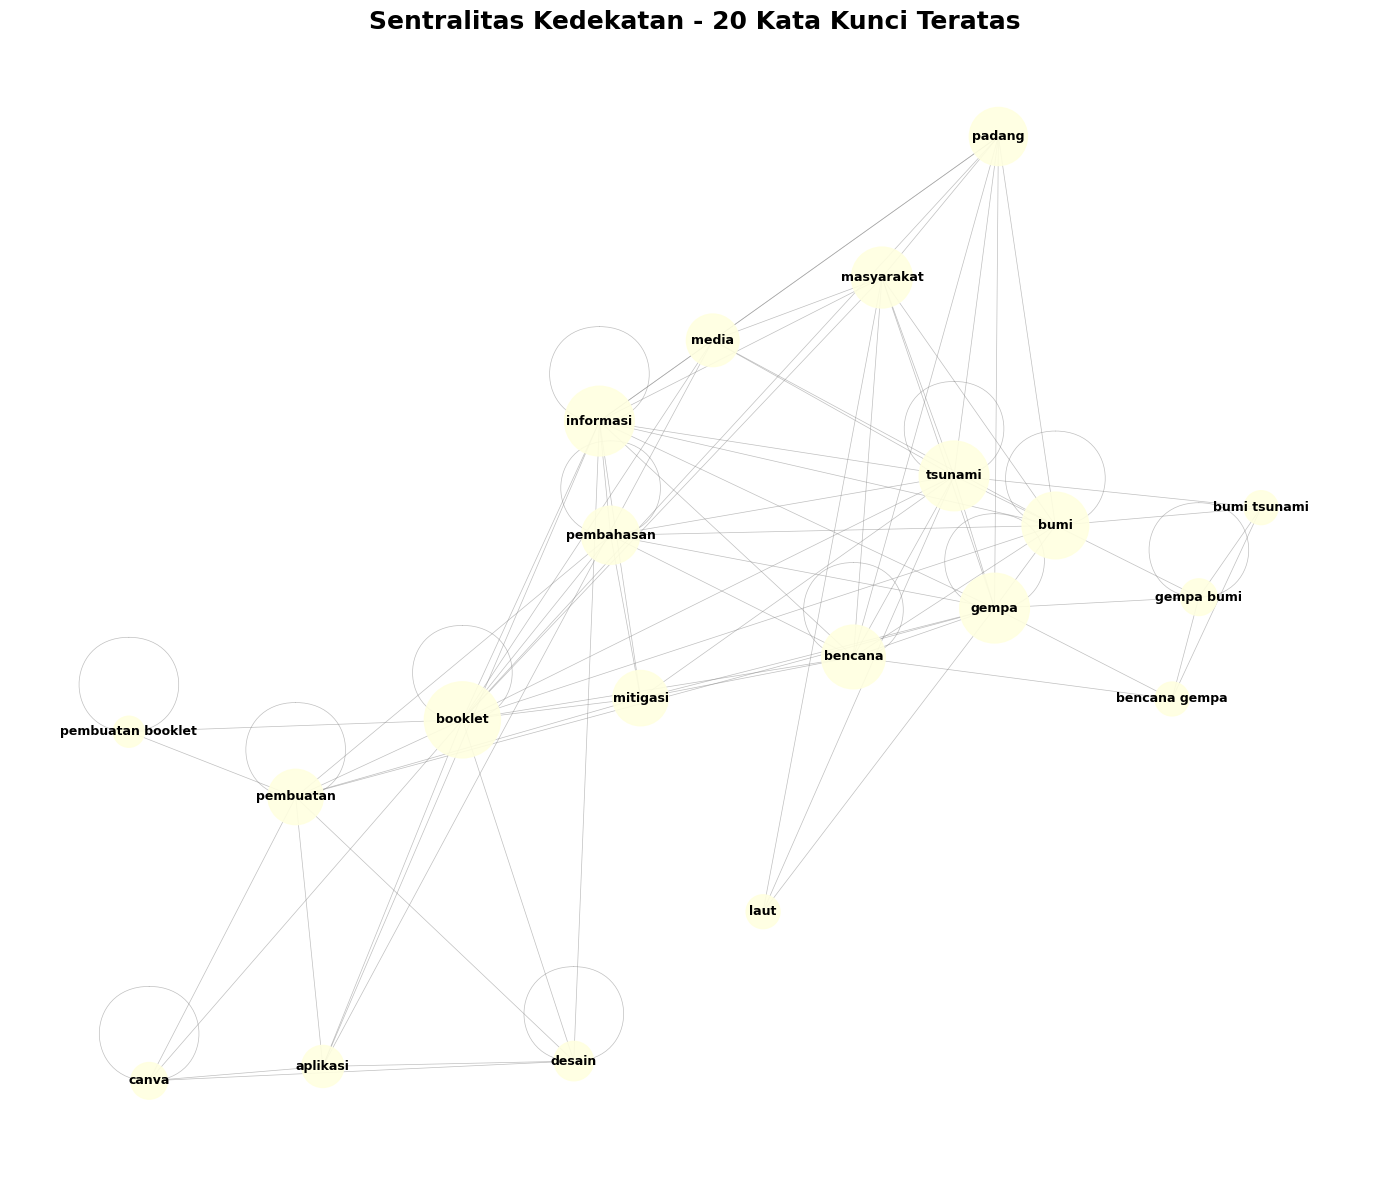

In [82]:
# Visualisasi Closeness Centrality
plt.figure(figsize=(14, 12))
pos = nx.spring_layout(subgraph, k=0.8, iterations=50)

# Normalisasi ukuran node berdasarkan closeness centrality
max_clo = max(closeness_centrality.values())
min_clo = min(closeness_centrality.values())
node_sizes = [500 + (v - min_clo) / (max_clo - min_clo) * 2500 if max_clo != min_clo else 1000 for v in closeness_centrality.values()]

nx.draw_networkx_nodes(subgraph, pos, node_size=node_sizes, node_color='lightyellow', alpha=0.9)
nx.draw_networkx_edges(subgraph, pos, width=0.5, alpha=0.5, edge_color='gray')
nx.draw_networkx_labels(subgraph, pos, font_size=9, font_weight='bold')

plt.title("Sentralitas Kedekatan - 20 Kata Kunci Teratas", fontsize=18, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()

In [83]:
# Ringkasan: Semua Ukuran Sentralitas Digabungkan
summary_df = pd.DataFrame({
    'Kata': pagerank_df['Kata'],
    'PageRank': pagerank_df['PageRank'].values,
    'Degree': [degree_centrality_sub[node] for node in pagerank_df['Kata']],
    'Betweenness': [betweenness_centrality[node] for node in pagerank_df['Kata']],
    'Closeness': [closeness_centrality[node] for node in pagerank_df['Kata']]
})

print("\n" + "="*90)
print("RINGKASAN: SEMUA UKURAN SENTRALITAS UNTUK 20 KATA KUNCI TERATAS")
print("="*90)
print(summary_df.to_string(index=False))

# Simpan hasil ke file CSV
summary_df.to_csv('hasil_ekstraksi_kata_kunci.csv', index=False)
print("\nHasil disimpan ke 'hasil_ekstraksi_kata_kunci.csv'")


RINGKASAN: SEMUA UKURAN SENTRALITAS UNTUK 20 KATA KUNCI TERATAS
             Kata  PageRank   Degree  Betweenness  Closeness
            gempa  0.110033 0.736842     0.134122   0.730769
             bumi  0.105514 0.684211     0.082048   0.703704
          booklet  0.097200 0.842105     0.201620   0.791667
       gempa bumi  0.074599 0.315789     0.003991   0.500000
          bencana  0.069270 0.631579     0.043994   0.678571
          tsunami  0.068388 0.736842     0.087202   0.730769
        pembuatan  0.053681 0.526316     0.069314   0.612903
     bumi tsunami  0.048137 0.210526     0.006196   0.487179
    bencana gempa  0.044832 0.210526     0.006010   0.487179
         mitigasi  0.040689 0.368421     0.005198   0.612903
        informasi  0.039375 0.736842     0.074341   0.730769
            canva  0.037669 0.315789     0.000000   0.500000
pembuatan booklet  0.037164 0.210526     0.000000   0.475000
       masyarakat  0.036088 0.473684     0.025316   0.655172
         aplikasi  0

## 14. Ringkasan Hasil

Menampilkan tabel ringkasan yang menggabungkan semua ukuran sentralitas untuk 20 kata kunci teratas. Tabel ini memudahkan perbandingan antar metrik dan menyimpan hasilnya ke file CSV.